# 1. addition air to the fuel stream

In [17]:
from __future__ import print_function
import cantera as ct
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import prettyplotlib as ppl
from prettyplotlib import brewer2mpl
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['font.family'] = 'Times New Roman'
colors = brewer2mpl.get_map('Set2','qualitative',8).mpl_colors

In [18]:
# Create directory for output data files
data_directory = 'diffusion_flame_extinction_data/'
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

#initial constant parameters
T1 = 310.0 #fuel inlet temperature
T2 = 296.0 #oxidizer inlet temperature
width = 0.0125 #distance between two ducts 12.5mm
temperature_limit_extinction = 500
#p = 101200
p = ct.one_atm
#variables
#1. equivalence ratio
phi1 = 0
phi2 = np.arange(0,0.35,0.05)
#2. composition 
comp_f = np.array([['N2:0.699075, CH3OCH3:0.300925, O2:0'],['N2:0.667674, CH3OCH3:0.300925, O2:0.031401'],['N2:0.636272, CH3OCH3:0.300925, O2:0.062803'],['N2:0.604871, CH3OCH3:0.300925, O2:0.094204'],['N2:0.573469, CH3OCH3:0.300925, O2:0.125606'],['N2:0.542067, CH3OCH3:0.300925, O2:0.157008']])
comp_o = np.array([['O2:0.214133, N2:0.785867, CH3OCH3:0'],['O2:0.199491, N2:0.800509, CH3OCH3:0'],['O2:0.184849, N2:0.815151, CH3OCH3:0'],['O2:0.170207, N2:0.829793, CH3OCH3:0'],['O2:0.155566, N2:0.844434, CH3OCH3:0'],['O2:0.140925, N2:0.859075, CH3OCH3:0'],['O2:0.214133, N2:0.755086, CH3OCH3:0.030781']])

In [19]:
extinc2_tot = []
for i in range(6):
    Yf_n2 = float(comp_f[i][0].rsplit(',')[0].rsplit(':')[1])
    Yf_dme = float(comp_f[i][0].rsplit(',')[1].rsplit(':')[1])
    Yf_o2 = float(comp_f[i][0].rsplit(',')[2].rsplit(':')[1])
    Yo_o2 = float(comp_o[i][0].rsplit(',')[0].rsplit(':')[1])
    Yo_n2 = float(comp_o[i][0].rsplit(',')[1].rsplit(':')[1])
    Yo_dme = float(comp_o[i][0].rsplit(',')[2].rsplit(':')[1])

    X_tot1 = Yf_n2/28.0134 + Yf_dme/46.07 + Yf_o2/31.9988 
    Xf_n2 = Yf_n2/28.0134/X_tot1
    Xf_dme = Yf_dme/46.07/X_tot1
    Xf_o2 = Yf_o2/31.9988/X_tot1 

    X_tot2 = Yo_o2/31.9988 + Yo_n2/28.0134 + Yo_dme/46.07
    Xo_o2 = Yo_o2/31.9988/X_tot2
    Xo_n2 = Yo_n2/28.0134/X_tot2
    Xo_dme = Yo_dme/46.07/X_tot2

    R = 8.314 # ideal gas constant
    rho1 = p*(Xf_n2*28.0134 + Xf_dme*46.07 + Xf_o2*31.9988)/(R*T1) #g/m3
    rho2 = p*(Xo_o2*31.9988 + Xo_n2*28.0134 + Xo_dme*46.07)/(R*T2)

    a2 = 100 #initial guess of strain rate of oxizidation duct
    rho_ratio = rho1/rho2
    V2 = a2*width/4
    V1 = V2/np.sqrt(rho_ratio) #momentum balance equation
    mdot_o = rho2/1000*V2
    mdot_f = rho1/1000*V1
    loglevel = 1 #amount of diagostic output (0-5)

    reaction_mechanism = 'DME_CK.cti'
    gas = ct.Solution(reaction_mechanism)
    f = ct.CounterflowDiffusionFlame(gas, width = width)
    f.P = p

    # Define the operating pressure and boundary conditions
    #fuel inlet
    f.fuel_inlet.mdot = mdot_f
    f.fuel_inlet.Y = comp_f[i][0]
    f.fuel_inlet.T = T1

    #oxidizer inlet
    f.oxidizer_inlet.mdot = mdot_o
    f.oxidizer_inlet.Y = comp_o[i][0]
    f.oxidizer_inlet.T = T2
    
    #set the boundary emissivities
    f.set_boundary_emissivities(0.0,0.0)#e_left, e_right

    #set criteria used for grid refinement
    f.set_refine_criteria(ratio=3.0, slope=0.1, curve=0.2, prune=0.03)
    #f.set_refine_criteria(ratio = 4, #add additional points when the ratio of the spacing on either side of a grid point exceeds this value
    #                      slope = 0.2, #add points in regions of high slope (max difference in points)
    #                      curve = 0.3, #add points in regions of high curvature (max difference in slope)
    #                      prune = 0.04)
    # Initialize and solve
    print('Creating the initial solution')
    f.solve(loglevel=0, auto=True)
    # Save to data directory
    file_name = 'initial_solution.xml'
    f.save(data_directory + file_name, name='solution',
           description='Cantera version ' + ct.__version__ +
           ', reaction mechanism ' + reaction_mechanism)

    #iteration
    exp_d_a = - 1. / 2.
    exp_u_a = 1. / 2.
    exp_V_a = 1.
    exp_lam_a = 2.
    exp_mdot_a = 1. / 2.

    # Set normalized initial strain rate
    alpha = [1.]
    # Initial relative strain rate increase
    delta_alpha = 1.
    # Factor of refinement of the strain rate increase
    delta_alpha_factor = 50.
    # Limit of the refinement: Minimum normalized strain rate increase
    delta_alpha_min = .001
    # Limit of the Temperature decrease
    delta_T_min = 1  # K

    # Iteration indicator
    n = 0
    # Indicator of the latest flame still burning
    n_last_burning = 0
    # List of peak temperatures
    T_max = [np.max(f.T)]
    # List of maximum axial velocity gradients
    a_max = [np.max(np.abs(np.gradient(f.u) / np.gradient(f.grid)))]
    a2_extinc = [4*np.abs(f.u[-1])/np.abs(f.grid[-1] - f.grid[0])]

    while True:
        n = n + 1
        # Update relative strain rates
        alpha.append(alpha[n_last_burning] + delta_alpha)
        strain_factor = alpha[-1] / alpha[n_last_burning]
        # Create an initial guess based on the previous solution
        # Update grid
        f.flame.grid *= strain_factor ** exp_d_a
        normalized_grid = f.grid / (f.grid[-1] - f.grid[0])
        # Update mass fluxes
        f.fuel_inlet.mdot *= strain_factor ** exp_mdot_a
        f.oxidizer_inlet.mdot *= strain_factor ** exp_mdot_a
        # Update velocities
        f.set_profile('u', normalized_grid, f.u * strain_factor ** exp_u_a)
        f.set_profile('V', normalized_grid, f.V * strain_factor ** exp_V_a)
        # Update pressure curvature
        f.set_profile('lambda', normalized_grid, f.L * strain_factor ** exp_lam_a)
        try:
            f.solve(loglevel=0)
        except Exception as e:
            # Throw Exception if solution fails
            print('Error: Did not converge at n =', n, e)

        if np.max(f.T) > temperature_limit_extinction:
            # Flame still burning, so go to next strain rate
            n_last_burning = n
            file_name = 'extinction_{0:04d}.xml'.format(n)
            f.save(data_directory + file_name, name='solution', loglevel=0,
                   description='Cantera version ' + ct.__version__ +
                   ', reaction mechanism ' + reaction_mechanism)
            T_max.append(np.max(f.T))
            a_max.append(np.max(np.abs(np.gradient(f.u) / np.gradient(f.grid))))
            a2_extinc.append(4*np.abs(f.u[-1])/np.abs(f.grid[-1] - f.grid[0]))
            # If the temperature difference is too small and the minimum relative
            # strain rate increase is reached, abort
            if ((T_max[-2] - T_max[-1] < delta_T_min) &
                    (delta_alpha < delta_alpha_min)):
                print('Flame extinguished at n = {0}.'.format(n),
                      'Abortion criterion satisfied.')
                break
        else:
            # Procedure if flame extinguished but abortion criterion is not satisfied
            print('Flame extinguished at n = {0}. Restoring n = {1} with alpha = {2}'.format(
                  n, n_last_burning, alpha[n_last_burning]))
            # Reduce relative strain rate increase
            delta_alpha = delta_alpha / delta_alpha_factor
            # Restore last burning solution
            file_name = 'extinction_{0:04d}.xml'.format(n_last_burning)
            f.restore(data_directory + file_name, name='solution', loglevel=0)
    extinc2_tot.append(a2_extinc[-1])




**** WARNING ****
For species C2H4OOH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  18.4211
	Value computed using high-temperature polynomial: 18.7409


**** WARNING ****
For species C2H4OOH, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  14.778
	Value computed using high-temperature polynomial: 14.7264


**** WARNING ****
For species OC2H3OOH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  18.7616
	Value computed using high-temperature polynomial: 19.0815


**** WARNING ****
For species OC2H3OOH, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  -18.695
	Value computed using high-temperature polynomial: -18.741


**** WARNING ****
For species CH2CH2OH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  15.1078
	Value computed using high-tempe

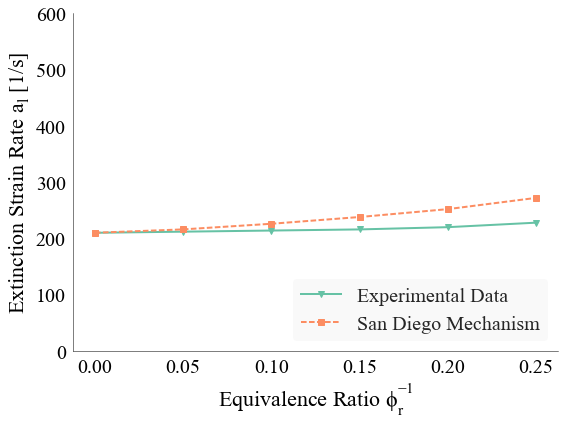

In [20]:
plt.figure(figsize=(8,6))
eq_ratio = np.arange(0,0.3,0.05)
experiment = np.array([210,212,214,216,220,228])
ppl.plot(eq_ratio,experiment,'-v',linewidth=2,label = 'Experimental Data')
ppl.plot(eq_ratio,np.array(extinc2_tot),'--s',linewidth=2,label = 'San Diego Mechanism')
plt.xlabel('Equivalence Ratio $\mathregular{\phi_r^{-1}}}$',fontsize=22)
plt.ylabel('Extinction Strain Rate $\mathregular{a_l}$ [1/s]',fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,600])
ppl.legend(loc='lower right',framealpha=0.75,prop={'size':20})
plt.tight_layout()
plt.savefig('case2.png',dpi=600)

# 2. addition DME to the oxidizer stream

In [24]:
# Create directory for output data files
data_directory = 'diffusion_flame_extinction_data/'
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

#initial constant parameters
T1 = 310.0 #fuel inlet temperature
T2 = 296.0 #oxidizer inlet temperature
width = 0.0125 #distance between two ducts 12.5mm
temperature_limit_extinction = 500
p = 101200
#p = ct.one_atm
#variables
#1. equivalence ratio
phi1 = 0
phi2 = np.arange(0,0.35,0.05)
#2. composition 
comp_f = np.array([['N2:0.699075, CH3OCH3:0.300925, O2:0'],['N2:0.712197, CH3OCH3:0.287803, O2:0'],['N2:0.725320, CH3OCH3:0.274680, O2:0'],['N2:0.738442, CH3OCH3:0.261558, O2:0'],['N2:0.751564, CH3OCH3:0.248436, O2:0'],['N2:0.764686, CH3OCH3:0.235314, O2:0'],['N2:0.777808, CH3OCH3:0.2222192, O2:0']])
comp_o = np.array([['O2:0.214133, N2:0.785867, CH3OCH3:0'],['O2:0.214133, N2:0.780737, CH3OCH3:0.005130'],['O2:0.214133, N2:0.775607, CH3OCH3:0.010260'],['O2:0.214133, N2:0.770477, CH3OCH3:0.015390'],['O2:0.214133, N2:0.765346, CH3OCH3:0.020521'],['O2:0.214133, N2:0.760216, CH3OCH3:0.025651'],['O2:0.214133, N2:0.755086, CH3OCH3:0.030781']])

In [25]:
extinc2_tot = []
for i in range(7):
    Yf_n2 = float(comp_f[i][0].rsplit(',')[0].rsplit(':')[1])
    Yf_dme = float(comp_f[i][0].rsplit(',')[1].rsplit(':')[1])
    Yf_o2 = float(comp_f[i][0].rsplit(',')[2].rsplit(':')[1])
    Yo_o2 = float(comp_o[i][0].rsplit(',')[0].rsplit(':')[1])
    Yo_n2 = float(comp_o[i][0].rsplit(',')[1].rsplit(':')[1])
    Yo_dme = float(comp_o[i][0].rsplit(',')[2].rsplit(':')[1])

    X_tot1 = Yf_n2/28.0134 + Yf_dme/46.07 + Yf_o2/31.9988 
    Xf_n2 = Yf_n2/28.0134/X_tot1
    Xf_dme = Yf_dme/46.07/X_tot1
    Xf_o2 = Yf_o2/31.9988/X_tot1 

    X_tot2 = Yo_o2/31.9988 + Yo_n2/28.0134 + Yo_dme/46.07
    Xo_o2 = Yo_o2/31.9988/X_tot2
    Xo_n2 = Yo_n2/28.0134/X_tot2
    Xo_dme = Yo_dme/46.07/X_tot2

    R = 8.314 # ideal gas constant
    rho1 = p*(Xf_n2*28.0134 + Xf_dme*46.07 + Xf_o2*31.9988)/(R*T1) #g/m3
    rho2 = p*(Xo_o2*31.9988 + Xo_n2*28.0134 + Xo_dme*46.07)/(R*T2)

    a2 = 100 #initial guess of strain rate of oxizidation duct
    rho_ratio = rho1/rho2
    V2 = a2*width/4
    V1 = V2/np.sqrt(rho_ratio) #momentum balance equation
    mdot_o = rho2/1000*V2
    mdot_f = rho1/1000*V1
    loglevel = 1 #amount of diagostic output (0-5)

    reaction_mechanism = 'DME_CK.cti'
    gas = ct.Solution(reaction_mechanism)
    f = ct.CounterflowDiffusionFlame(gas, width = width)
    f.P = p

    # Define the operating pressure and boundary conditions
    #fuel inlet
    f.fuel_inlet.mdot = mdot_f
    f.fuel_inlet.Y = comp_f[i][0]
    f.fuel_inlet.T = T1

    #oxidizer inlet
    f.oxidizer_inlet.mdot = mdot_o
    f.oxidizer_inlet.Y = comp_o[i][0]
    f.oxidizer_inlet.T = T2

    #set the boundary emissivities
    f.set_boundary_emissivities(0.0,0.0)#e_left, e_right

    #set criteria used for grid refinement
    f.set_refine_criteria(ratio=3.0, slope=0.1, curve=0.2, prune=0.03)
    #f.set_refine_criteria(ratio = 4, #add additional points when the ratio of the spacing on either side of a grid point exceeds this value
    #                      slope = 0.2, #add points in regions of high slope (max difference in points)
    #                      curve = 0.3, #add points in regions of high curvature (max difference in slope)
    #                      prune = 0.04)
    # Initialize and solve
    print('Creating the initial solution')
    f.solve(loglevel=0, auto=True)
    # Save to data directory
    file_name = 'initial_solution.xml'
    f.save(data_directory + file_name, name='solution',
           description='Cantera version ' + ct.__version__ +
           ', reaction mechanism ' + reaction_mechanism)

    #iteration
    exp_d_a = - 1. / 2.
    exp_u_a = 1. / 2.
    exp_V_a = 1.
    exp_lam_a = 2.
    exp_mdot_a = 1. / 2.

    # Set normalized initial strain rate
    alpha = [1.]
    # Initial relative strain rate increase
    delta_alpha = 1.
    # Factor of refinement of the strain rate increase
    delta_alpha_factor = 50.
    # Limit of the refinement: Minimum normalized strain rate increase
    delta_alpha_min = .001
    # Limit of the Temperature decrease
    delta_T_min = 1  # K

    # Iteration indicator
    n = 0
    # Indicator of the latest flame still burning
    n_last_burning = 0
    # List of peak temperatures
    T_max = [np.max(f.T)]
    # List of maximum axial velocity gradients
    a_max = [np.max(np.abs(np.gradient(f.u) / np.gradient(f.grid)))]
    a2_extinc = [4*np.abs(f.u[-1])/np.abs(f.grid[-1] - f.grid[0])]

    while True:
        n = n + 1
        # Update relative strain rates
        alpha.append(alpha[n_last_burning] + delta_alpha)
        strain_factor = alpha[-1] / alpha[n_last_burning]
        # Create an initial guess based on the previous solution
        # Update grid
        f.flame.grid *= strain_factor ** exp_d_a
        normalized_grid = f.grid / (f.grid[-1] - f.grid[0])
        # Update mass fluxes
        f.fuel_inlet.mdot *= strain_factor ** exp_mdot_a
        f.oxidizer_inlet.mdot *= strain_factor ** exp_mdot_a
        # Update velocities
        f.set_profile('u', normalized_grid, f.u * strain_factor ** exp_u_a)
        f.set_profile('V', normalized_grid, f.V * strain_factor ** exp_V_a)
        # Update pressure curvature
        f.set_profile('lambda', normalized_grid, f.L * strain_factor ** exp_lam_a)
        try:
            f.solve(loglevel=0)
        except Exception as e:
            # Throw Exception if solution fails
            print('Error: Did not converge at n =', n, e)

        if np.max(f.T) > temperature_limit_extinction:
            # Flame still burning, so go to next strain rate
            n_last_burning = n
            file_name = 'extinction_{0:04d}.xml'.format(n)
            f.save(data_directory + file_name, name='solution', loglevel=0,
                   description='Cantera version ' + ct.__version__ +
                   ', reaction mechanism ' + reaction_mechanism)
            T_max.append(np.max(f.T))
            a_max.append(np.max(np.abs(np.gradient(f.u) / np.gradient(f.grid))))
            a2_extinc.append(4*np.abs(f.u[-1])/np.abs(f.grid[-1] - f.grid[0]))
            # If the temperature difference is too small and the minimum relative
            # strain rate increase is reached, abort
            if ((T_max[-2] - T_max[-1] < delta_T_min) &
                    (delta_alpha < delta_alpha_min)):
                print('Flame extinguished at n = {0}.'.format(n),
                      'Abortion criterion satisfied.')
                break
        else:
            # Procedure if flame extinguished but abortion criterion is not satisfied
            print('Flame extinguished at n = {0}. Restoring n = {1} with alpha = {2}'.format(
                  n, n_last_burning, alpha[n_last_burning]))
            # Reduce relative strain rate increase
            delta_alpha = delta_alpha / delta_alpha_factor
            # Restore last burning solution
            file_name = 'extinction_{0:04d}.xml'.format(n_last_burning)
            f.restore(data_directory + file_name, name='solution', loglevel=0)
    extinc2_tot.append(a2_extinc[-1])



**** WARNING ****
For species C2H4OOH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  18.4211
	Value computed using high-temperature polynomial: 18.7409


**** WARNING ****
For species C2H4OOH, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  14.778
	Value computed using high-temperature polynomial: 14.7264


**** WARNING ****
For species OC2H3OOH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  18.7616
	Value computed using high-temperature polynomial: 19.0815


**** WARNING ****
For species OC2H3OOH, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  -18.695
	Value computed using high-temperature polynomial: -18.741


**** WARNING ****
For species CH2CH2OH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  15.1078
	Value computed using high-tempe

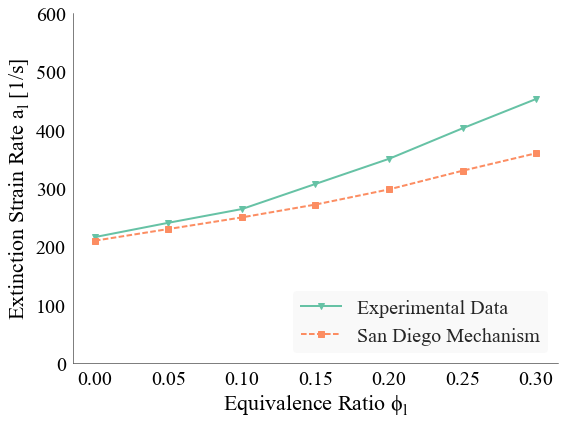

In [26]:
plt.figure(figsize=(8,6))
eq_ratio = np.arange(0,0.35,0.05)
experiment = np.array([216.254,240.817,264.351,307.432,350.512,402.855,453.137])
ppl.plot(eq_ratio,experiment,'-v',linewidth=2,label = 'Experimental Data')
ppl.plot(eq_ratio,np.array(extinc2_tot),'--s',linewidth=2,label = 'San Diego Mechanism')
plt.xlabel('Equivalence Ratio $\mathregular{\phi_l}}$',fontsize=22)
plt.ylabel('Extinction Strain Rate $\mathregular{a_l}$ [1/s]',fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,600])
ppl.legend(loc='lower right',framealpha=0.75,prop={'size':20})
plt.tight_layout()
plt.savefig('case1.png',dpi=600)